In [1]:
import numpy as np
import pandas as pd
from tifffile import imread
import matplotlib.pyplot as plt
import dill as pkl

In [2]:
directions = [[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1]]

def dfs_with_limit(start_x, start_y, temp_img, visited, path, limit):
    if temp_img[start_x,start_y] == 0 or visited[start_x, start_y] != 0 or len(path) >= limit:
        return
    path.append([start_x,start_y])
    visited[start_x, start_y] = 1
    for direction in directions:
        dx, dy = direction[0], direction[1]
        dfs_with_limit(start_x+dx, start_y+dy, temp_img, visited, path, limit)

x, y, window_size = 1000, 1000, 50
ndvi_path = '../../data/geospatial_data/durham/durham_ndvi.tif'
temp_path = '../../data/geospatial_data/durham/durham_temp.tif'
ndvi_img = imread(ndvi_path)[200:2201,200:2201]
temp_img = imread(temp_path)[200:2201,200:2201]
temp_x, temp_y = np.where(temp_img != 0)
start_x, start_y, path = temp_x[8500], temp_y[8500], []
visited = np.zeros_like(temp_img)
dfs_with_limit(start_x, start_y, temp_img, visited, path, 60)
print(len(path))

36


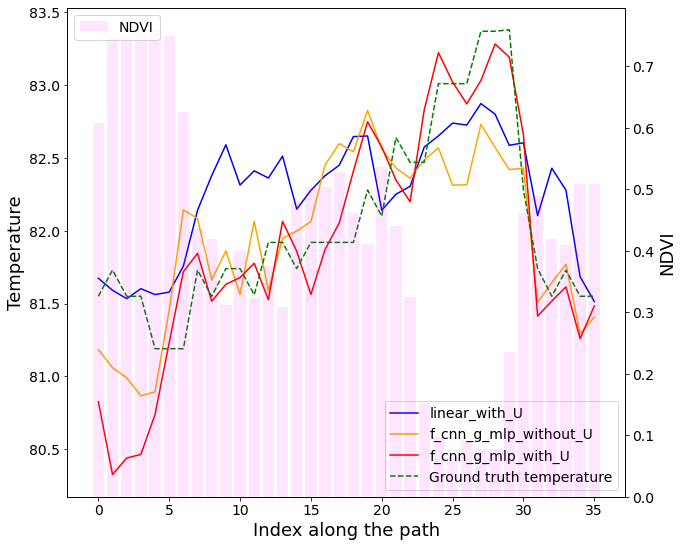

In [3]:
with open('./results_geospatial_real.pkl','rb') as fp:
    res = pkl.load(fp)

model_names = [
    'linear_with_U',
    'f_cnn_g_mlp_without_U',
    'f_cnn_g_mlp_with_U',
]
colors = ['blue', 'orange','red']
ls = ['-', '-','-']

fig, ax1 = plt.subplots(1, 1, figsize=(10,9))
ax2 = ax1.twinx()
x_coord = np.linspace(0, len(path)-1, len(path))
for i in range(len(model_names)):
    ax1.plot(
        x_coord, 
        np.array([res[model_names[i]][coord[0],coord[1]] for coord in path]), 
        color=colors[i], 
        ls=ls[i], 
        label=model_names[i]
    )
ax1.plot(
    x_coord,
    np.array([temp_img[coord[0],coord[1]] for coord in path]),
    color='green',
    ls='--',
    label='Ground truth temperature'
)
ax2.bar(
    x_coord, 
    np.array([ndvi_img[coord[0],coord[1]] for coord in path]), 
    color='magenta', 
    alpha=0.1, 
    label='NDVI'
)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(loc=4, prop={'size':14})
ax2.legend(loc=2, prop={'size':14})
ax1.set_xlabel('Index along the path', fontsize=18)
ax1.set_ylabel('Temperature', fontsize=18)
ax2.set_ylabel('NDVI', fontsize=18)
plt.savefig("./temp_ndvi_spatial_variation.pdf", dpi=600)

In [5]:
# Calculate the prediction statistics of temperature for low-NDVI, medium-NDVI and high-NDVI regions
from scipy.stats import linregress
from sklearn import metrics

model_names = [
    'linear_without_U',
    'linear_with_U',
    'f_cnn_g_mlp_without_U',
    'f_cnn_g_mlp_with_U',
    'f_unet_g_mlp_without_U',
    'f_unet_g_mlp_with_U',
]
ndvi_true = [ndvi_img[col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)]
ndvi_30, ndvi_70 = np.percentile(ndvi_true, 30), np.percentile(ndvi_true, 70)

print("Low NDVI region: \n" + "=" * 100)
for model_name in model_names:
    y_pred = [
        res[model_name][col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_img[col_x,col_y] <= ndvi_30
    ]
    y_true = [
        temp_img[col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_img[col_x,col_y] <= ndvi_30
    ]
    _, _, r_value, p_value, _ = linregress(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    print(f"Model: {model_name}:")
    print(f"R squared: {r_value ** 2}, p-value: {p_value}, MSE: {mse}, MAE: {mae}\n")

print("Medium NDVI region: \n" + "=" * 100)
for model_name in model_names:
    y_pred = [
        res[model_name][col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_30 < ndvi_img[col_x,col_y] <= ndvi_70
    ]
    y_true = [
        temp_img[col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_30 < ndvi_img[col_x,col_y] <= ndvi_70
    ]
    _, _, r_value, p_value, _ = linregress(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    print(f"Model: {model_name}:")
    print(f"R squared: {r_value ** 2}, p-value: {p_value}, MSE: {mse}, MAE: {mae}\n")

print("High NDVI region: \n" + "=" * 100)
for model_name in model_names:
    y_pred = [
        res[model_name][col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_img[col_x,col_y] > ndvi_70
    ]
    y_true = [
        temp_img[col_x,col_y] for col_x, col_y in zip(temp_x, temp_y)
        if ndvi_img[col_x,col_y] > ndvi_70
    ]
    _, _, r_value, p_value, _ = linregress(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    print(f"Model: {model_name}:")
    print(f"R squared: {r_value ** 2}, p-value: {p_value}, MSE: {mse}, MAE: {mae}\n")

Low NDVI region: 
Model: linear_without_U:
R squared: 0.35768360757184087, p-value: 0.0, MSE: 1.945869685011784, MAE: 1.0991892810499813

Model: linear_with_U:
R squared: 0.38641130131871865, p-value: 0.0, MSE: 1.8494840170975124, MAE: 1.0533933514105107

Model: f_cnn_g_mlp_without_U:
R squared: 0.5990284989871529, p-value: 0.0, MSE: 1.214992031376368, MAE: 0.811741206361906

Model: f_cnn_g_mlp_with_U:
R squared: 0.5842826917955943, p-value: 0.0, MSE: 1.252803434996804, MAE: 0.8088466416248524

Model: f_unet_g_mlp_without_U:
R squared: 0.40369008992016975, p-value: 0.0, MSE: 1.7541113125657921, MAE: 1.0511049640456356

Model: f_unet_g_mlp_with_U:
R squared: 0.41521450811433486, p-value: 0.0, MSE: 1.7308224480934078, MAE: 1.0355271283859122

Medium NDVI region: 
Model: linear_without_U:
R squared: 0.35577465618418597, p-value: 0.0, MSE: 2.2914111044601007, MAE: 1.234302557350977

Model: linear_with_U:
R squared: 0.3868695715371625, p-value: 0.0, MSE: 2.154810143999875, MAE: 1.1760624963